## Ising Model Partition Functions Zero via Wang-Landau

<!-- Take the Ising model partition function,
$$ \mathcal{Z}(\beta,h) = \sum_{ \{ s_i \} } \exp( -\beta \mathcal{H} )$$
$$ \mathcal{Z}(\beta,h) = \sum_{ \{ s_i \} } \exp( -\beta \mathcal{H} )$$
or in terms of the density of states -->

__Goals:__
1. Recover the expected result for square lattice Ising
2. Explore anti-ferromagnetic zeros
3. Explore spin s zeros
3. Recover critical exponents and amplitudes

In [1]:
import matplotlib.pyplot as plt, numpy as np
from time import time

In [2]:
class Wang_Landau_2DIsing:
    """
    Implements the Wang-Landau algorithm for a 2D Ising model on a square lattice with even side lengths initilized on a random spin lattice.

    Attributes:
        L (int): The side length of the square lattice.
        J (float): The coupling constant (default is 1).
        lattice (np.ndarray): The 2D lattice of spins (-1 or 1).
        energy_spectrum (np.ndarray): The possible energy states for the lattice.
        mag_spectrum (np.ndarray): The possible magnetization states for the lattice.
        logf (float): The logarithmic modification factor for Wang-Landau sampling.
        total_energy (int): The total energy of the initial lattice configuration.
        total_mag (int): The total magnetization of the initial lattice configuration.
    """

    def __init__(self, L: int, J = 1):
        if L % 2 != 0 or not isinstance(L, int):
            raise ValueError("L must be an even integer.")
        
        self.L = L
        self.J = J
        self.lattice = np.random.choice([-1, 1], size=(L, L))
        self.energy_spectrum = self.get_energy_spectrum()
        self.mag_spectrum = np.arange(-L**2,L**2+1,2)
        self.logf = 1
        self.total_energy = self.calculate_energy()
        self.total_mag = np.sum(self.lattice)
    
    def get_energy_spectrum(self):
        ''' Generates list of energies for even L '''
        if self.L % 2 != 0:
            raise ValueError("This spectrum generation only works for even side lengths.")

        energy_spectrum = [-2*self.L**2 + 4*k for k in range(0,self.L**2+1)]
        energy_spectrum.pop(1)
        energy_spectrum.pop(-2)
        energy_spectrum = np.array(energy_spectrum)  # number of energy states = N-1

        return energy_spectrum
        
    def calculate_energy(self):
        energy = 0
        for i in range(self.L):
            for j in range(self.L):
                energy += -self.J * self.lattice[i, j] * (
                    self.lattice[(i+1)%self.L, j] + 
                    self.lattice[i, (j+1)%self.L] )
        return energy
    
    def random_spin_flip(self):
        i, j = np.random.randint(0, self.L, 2)
        delta_E = 2 * self.J * self.lattice[i, j] * (
            self.lattice[(i+1)%self.L, j] + 
            self.lattice[(i-1)%self.L, j] + 
            self.lattice[i, (j+1)%self.L] + 
            self.lattice[i, (j-1)%self.L] )
        return i, j, delta_E
    
    def calculate_energy_probablities(self, T = 1):
        log_partition_function = np.logaddexp.reduce([g - e / T for g, e in zip(self.dos, self.energy_spectrum)])
        return [np.exp(g - e / T - log_partition_function) for g, e in zip(self.dos, self.energy_spectrum)]
    
    def Z_of_h_coeffs(self, beta):
        # Normalize mag levels to start from zero
        min_mag = np.min(self.mag_spectrum)
        polynomial_degree = int(2*np.max(self.mag_spectrum))
        coefficients = np.zeros(polynomial_degree + 1)
        for (i,j), g in np.ndenumerate(self.dos):
            E = self.energy_spectrum[i]
            M = self.mag_spectrum[j] - min_mag
            coefficients[int(M)] += g*np.exp(-beta*E)
        return coefficients
    
    def calculate_thermo_scalar(self, beta):
        
        log_partition_function = np.logaddexp.reduce(self.log_dos - beta * self.energy_spectrum)
        boltzman_weights_normalized = np.exp(self.log_dos - beta * self.energy_spectrum - log_partition_function)

        average_energy = np.sum(self.energy_spectrum * boltzman_weights_normalized)
        average_energy_squared = np.sum(self.energy_spectrum**2 * boltzman_weights_normalized)
        specific_heat = beta**2*(average_energy_squared - average_energy**2)

        return average_energy, specific_heat
    
    def calculate_thermo(self, betas):
        betas = np.asarray(betas)  
        log_partition_functions = np.logaddexp.reduce(
            self.log_dos[:, None] - betas * self.energy_spectrum[:, None], axis=0
        )
        boltzmann_weights = np.exp(
            self.log_dos[:, None] - betas * self.energy_spectrum[:, None] - log_partition_functions
        )
        average_energy = np.sum(self.energy_spectrum[:, None] * boltzmann_weights, axis=0)
        average_energy_squared = np.sum(self.energy_spectrum[:, None]**2 * boltzmann_weights, axis=0)
        specific_heat = betas**2 * (average_energy_squared - average_energy**2)
        return average_energy, specific_heat

    def run_energy_density(self, logfmod = 1/2, logf_min = 1e-8, flatness_criterion = .8, N_sweeps = 1e2):

        self.dos = np.zeros_like(self.energy_spectrum, dtype=float)
        self.log_dos = np.zeros_like(self.dos, dtype=float)
        self.histogram = np.zeros_like(self.dos, dtype=int)
        
        index1 = np.argwhere( self.energy_spectrum == self.total_energy)[0,0]
        while self.logf > logf_min:
            iteration = 0
            self.histogram.fill(0)
            # while np.min(self.histogram) <= flatness_criterion * np.mean(self.histogram):
            while True:
                for s in range(int(N_sweeps*self.L**2)):
                    i, j, delta_E = self.random_spin_flip()
                    new_energy = self.total_energy + delta_E
                    index2 = np.argwhere( self.energy_spectrum == new_energy)[0,0]

                    if (np.log(np.random.random()) < self.log_dos[index1] - self.log_dos[index2]):
                        self.lattice[i, j] *= -1
                        self.total_energy = new_energy
                        index1 = index2
                    else:
                        index1 = index1

                    self.log_dos[index1] += self.logf
                    self.histogram[index1] += 1
                    iteration += 1

                # np.savetxt('log_dos_intermediate.txt', self.log_dos, delimiter=' ', fmt='%d')
                # np.savetxt('hist_intermediate.txt', self.histogram, delimiter=' ', fmt='%d')
                if np.min(self.histogram[self.histogram > 0]) > flatness_criterion * np.mean(self.histogram[self.histogram > 0]):
                    break

                
            print(f"ln(f) = {self.logf}", "and sweeps = ", iteration//self.L**2)
            self.logf *= logfmod
        
        #self.log_dos -= self.dos.min()
        self.log_dos -= (self.log_dos[0]-np.log(2))
        self.dos = np.exp(self.log_dos)

        return self.dos
    
    def run_magnetic_density(self, logfmod = 1/2, logf_min = 1e-8, flatness_criterion = .8, N_sweeps = 1e2):
    
        self.dos = np.zeros((len(self.mag_spectrum)),  dtype=float)
        self.log_dos = np.zeros_like(self.dos, dtype=float)
        self.histogram = np.zeros_like(self.dos, dtype=int)

        M_index1 = np.argwhere( self.mag_spectrum == self.total_mag)[0,0]

        while self.logf > logf_min:
            iteration = 0
            self.histogram.fill(0)
            # while np.min(self.histogram[self.histogram > 0]) <= flatness_criterion * np.mean(self.histogram[self.histogram > 0]):
            while True:
                for s in range(int(N_sweeps*self.L**2)):
                    i, j, delta_E = self.random_spin_flip()
                    new_mag = self.total_mag - 2*self.lattice[i,j]
                    M_index2 = np.argwhere( self.mag_spectrum == new_mag)[0,0]

                    if (np.log(np.random.random() ) < self.log_dos[M_index1] - self.log_dos[M_index2]):
                        self.lattice[i, j] *= -1
                        self.total_mag = new_mag
                        M_index1 = M_index2
                    else:
                        M_index1 = M_index1

                    self.log_dos[M_index1] += self.logf
                    self.histogram[M_index1] += 1
                    iteration += 1
                #np.savetxt('log_dos_intermediate.txt', self.log_dos, delimiter=' ', fmt='%d')
                #np.savetxt('hist_intermediate.txt', self.histogram, delimiter=' ', fmt='%d')
                if np.min(self.histogram[self.histogram > 0]) > flatness_criterion * np.mean(self.histogram[self.histogram > 0]):
                    break
                
            print(f"ln(f) = {self.logf}", "and sweeps = ", iteration//self.L**2)
            self.logf *= logfmod
        
        M_aligned_idx = np.argwhere( self.mag_spectrum == self.L**2)[0,0]
        for i, A in np.ndenumerate(self.log_dos):
            if A != 0:
                self.log_dos -= (self.log_dos[M_aligned_idx]-np.log(2))
                self.dos[i] = np.exp(self.log_dos[i])
        # self.dos *= 2/self.dos[M_aligned_idx] 
                
        return self.dos
        
    def run_joint_density(self, logfmod = 1/2, logf_min = 1e-8, flatness_criterion = .8, N_sweeps = 1e2):
    
        self.dos = np.zeros((len(self.energy_spectrum), len(self.mag_spectrum)),  dtype=float)
        self.log_dos = np.zeros_like(self.dos, dtype=float)
        self.histogram = np.zeros_like(self.dos, dtype=int)

        E_index1 = np.argwhere( self.energy_spectrum == self.total_energy)[0,0]
        M_index1 = np.argwhere( self.mag_spectrum == self.total_mag)[0,0]

        while self.logf > logf_min:
            iteration = 0
            self.histogram.fill(0)
            # while np.min(self.histogram[self.histogram > 0]) <= flatness_criterion * np.mean(self.histogram[self.histogram > 0]):
            while True:
                for s in range(int(N_sweeps*self.L**2)):
                    i, j, delta_E = self.random_spin_flip()
                    new_energy = self.total_energy + delta_E
                    new_mag = self.total_mag - 2*self.lattice[i,j]

                    E_index2 = np.argwhere( self.energy_spectrum == new_energy)[0,0]
                    M_index2 = np.argwhere( self.mag_spectrum == new_mag)[0,0]

                    if (np.log(np.random.random() ) < self.log_dos[E_index1, M_index1] - self.log_dos[E_index2, M_index2]):
                        self.lattice[i, j] *= -1
                        self.total_energy = new_energy
                        self.total_mag = new_mag
                        E_index1 = E_index2
                        M_index1 = M_index2
                    else:
                        E_index1 = E_index1
                        M_index1 = M_index1

                    self.log_dos[E_index1, M_index1] += self.logf
                    self.histogram[E_index1, M_index1] += 1
                    iteration += 1
                #np.savetxt('log_dos_intermediate.txt', self.log_dos, delimiter=' ', fmt='%d')
                #np.savetxt('hist_intermediate.txt', self.histogram, delimiter=' ', fmt='%d')
                if np.min(self.histogram[self.histogram > 0]) > flatness_criterion * np.mean(self.histogram[self.histogram > 0]):
                    break
                
            print(f"ln(f) = {self.logf}", "and sweeps = ", iteration//self.L**2)
            self.logf *= logfmod
        
        #self.log_dos[i] -= (self.log_dos[0]-np.log(2))
        E0_idx = np.argwhere( self.energy_spectrum == -2*self.J*self.L**2)[0,0]
        M_aligned_idx = np.argwhere( self.mag_spectrumrumrumrumrum == self.L**2)[0,0]
        for i, A in np.ndenumerate(self.log_dos):
            if A != 0:
                self.log_dos -= (self.log_dos[E0_idx,M_aligned_idx] - np.log(2))
                self.dos[i] = np.exp(self.log_dos[i])
        #self.dos *= 1/self.dos[E0_idx,M_aligned_idx] 
                
        return self.dos
            

## Complex Temperature Zeros

In [ ]:
# Run the simulation
L = 8
flatness = .9
model = Wang_Landau_2DIsing(L)
t0 = time()
dos = model.run_energy_density(logfmod = 1/2, logf_min = 1e-8, flatness_criterion = flatness, N_sweeps = 1e2)
print("Computation time = ", time()-t0)

ln(f) = 1 and sweeps =  2200
ln(f) = 0.5 and sweeps =  1100
ln(f) = 0.25 and sweeps =  1500
ln(f) = 0.125 and sweeps =  1200
ln(f) = 0.0625 and sweeps =  1100
ln(f) = 0.03125 and sweeps =  1200
ln(f) = 0.015625 and sweeps =  1600
ln(f) = 0.0078125 and sweeps =  1600
ln(f) = 0.00390625 and sweeps =  4100
ln(f) = 0.001953125 and sweeps =  4200
ln(f) = 0.0009765625 and sweeps =  5600
ln(f) = 0.00048828125 and sweeps =  9700
ln(f) = 0.000244140625 and sweeps =  14000
ln(f) = 0.0001220703125 and sweeps =  17000
ln(f) = 6.103515625e-05 and sweeps =  17000
ln(f) = 3.0517578125e-05 and sweeps =  41700
ln(f) = 1.52587890625e-05 and sweeps =  39600
ln(f) = 7.62939453125e-06 and sweeps =  24100
ln(f) = 3.814697265625e-06 and sweeps =  27600
ln(f) = 1.9073486328125e-06 and sweeps =  31200
ln(f) = 9.5367431640625e-07 and sweeps =  46000
ln(f) = 4.76837158203125e-07 and sweeps =  35800
ln(f) = 2.384185791015625e-07 and sweeps =  62900
ln(f) = 1.1920928955078125e-07 and sweeps =  12900
ln(f) = 5.9604

In [12]:
filename = f'WL_data/WL_L={L}_logmod=1o2_logf_min=1e-8_flat={90}.npy'

WL_data/WL_L=8_logmod=1o2_logf_min=1e-8_flat=90.npy


In [13]:
filename = f'WL_data/WL_L={L}_logmod=1o2_logf_min=1e-8_flat={90}.npy'
np.save(filename, dos)
# dos = np.load('WL_data/WL_L=30_logmod=1o2_logf_min=1e-8_flat=80.npy')

In [16]:
# Normalize energy levels to start from zero
min_energy = np.min(model.energy_spectrum)
normalized_energy_spectrum = model.energy_spectrum - min_energy
normalized_energy_spectrum = normalized_energy_spectrum//2

# Construct Z(beta): Polynomial in z with coefficients from g(E)
polynomial_degree = int(normalized_energy_spectrum[-1]) + 1
coefficients = np.zeros(polynomial_degree)

for i, E in enumerate(normalized_energy_spectrum):
    coefficients[int(E)] += dos[i]

# Find roots of Z(z) where z corresponds to exp(-beta)
zeros_z = np.roots(coefficients)
# zeros_z = zeros_z**1/2
zeros_beta = -np.log(zeros_z)

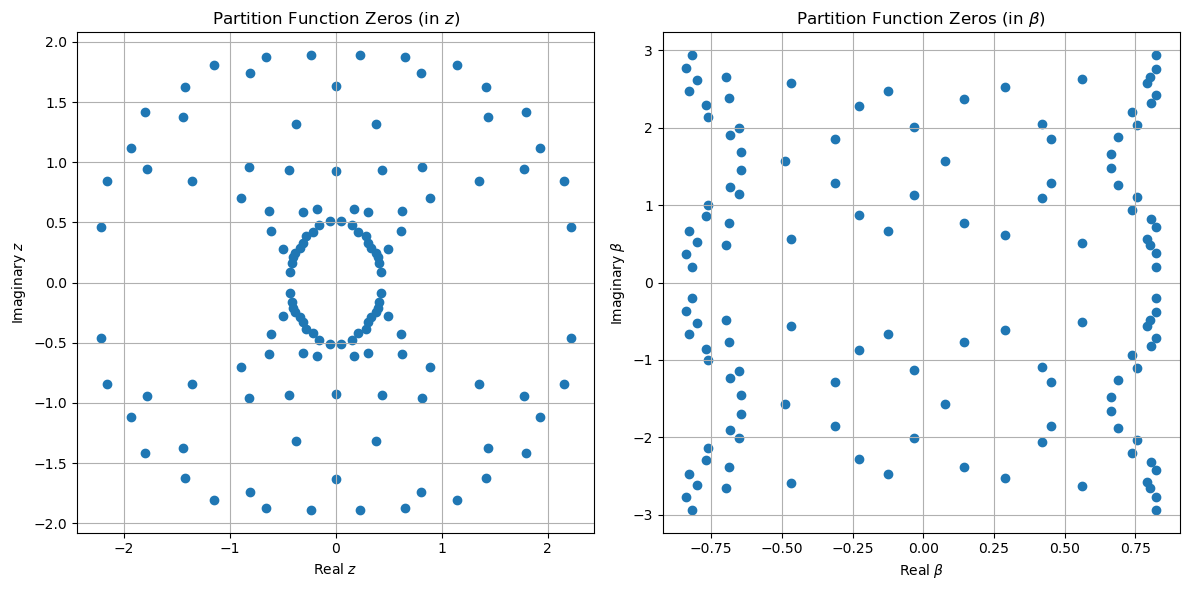

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot zeros in terms of z
axes[0].scatter(zeros_z.real, zeros_z.imag)
axes[0].set_xlabel(r'Real $z$')
axes[0].set_ylabel(r'Imaginary $z$')
axes[0].set_title('Partition Function Zeros (in $z$)')
axes[0].grid()

# Plot zeros in terms of beta
axes[1].scatter(zeros_beta.real, zeros_beta.imag)
# axes[1].set_xlim(-1,1)
# axes[1].set_ylim(-1,1)
axes[1].set_xlabel(r'Real $\beta$')
axes[1].set_ylabel(r'Imaginary $\beta$')
axes[1].set_title(r'Partition Function Zeros (in $\beta$)')
axes[1].grid()

plt.tight_layout()
plt.show()

## Complex External Field Zeros

In [ ]:
# Run the simulation
L = 10
model = Wang_Landau_2DIsing(L)
t0 = time()
dos = model.run_joint_density(logfmod = 1/4, logf_min = 1e-6, flatness_criterion = .9, N_sweeps = 1e2)
print("Computation time = ", time()-t0)

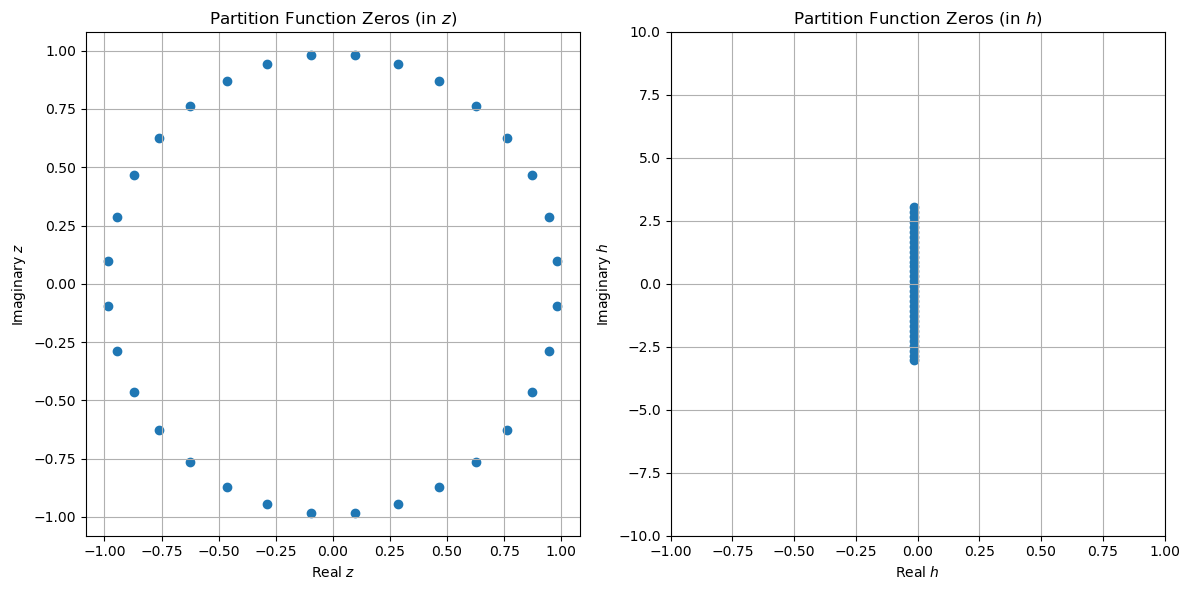

In [ ]:
beta = .3
coeffs = model.Z_of_h_coeffs(beta)

zeros_z = np.roots(coeffs)
zeros_h = np.log(zeros_z)/beta
# Plot zeros of the partition function in terms of h and fugacity(z)
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot zeros in terms of beta and h
axes[0].scatter(zeros_z.real, zeros_z.imag)
axes[0].set_xlabel(r'Real $z$')
axes[0].set_ylabel(r'Imaginary $z$')
axes[0].set_title('Partition Function Zeros (in $z$)')
axes[0].grid()

# Plot zeros in terms of beta and fugacity z
axes[1].scatter(zeros_h.real, zeros_h.imag)
axes[1].set_xlim(-1,1)
axes[1].set_ylim(-10,10)
axes[1].set_xlabel(r'Real $h$')
axes[1].set_ylabel(r'Imaginary $h$')
axes[1].set_title('Partition Function Zeros (in $h$)')
axes[1].grid()

plt.tight_layout()
plt.show()

## Benchmarking

In [3]:
# L = 30
# model = Wang_Landau_2DIsing(L)
# model.dos = np.load('WL_data/WL_L=30_logmod=1o2_logf_min=1e-8_flat=80.npy')
# model.log_dos = np.log(model.dos)

# np.save('WL_data/WL_L=6_logmod=1o2_logf_min=1e-8_flat=90.npy', model.dos)

In [6]:
# Run the simulation
L = 6
model = Wang_Landau_2DIsing(L)
t0 = time()
dos = model.run_energy_density(logfmod = 1/2, logf_min = 1e-8, flatness_criterion = .8, N_sweeps = 1e2)
print("Computation time = ", time()-t0)

ln(f) = 1 and sweeps =  400
ln(f) = 0.5 and sweeps =  400
ln(f) = 0.25 and sweeps =  400
ln(f) = 0.125 and sweeps =  400
ln(f) = 0.0625 and sweeps =  400
ln(f) = 0.03125 and sweeps =  500
ln(f) = 0.015625 and sweeps =  600
ln(f) = 0.0078125 and sweeps =  1100
ln(f) = 0.00390625 and sweeps =  1300
ln(f) = 0.001953125 and sweeps =  1100
ln(f) = 0.0009765625 and sweeps =  5000
ln(f) = 0.00048828125 and sweeps =  2100
ln(f) = 0.000244140625 and sweeps =  3300
ln(f) = 0.0001220703125 and sweeps =  2700
ln(f) = 6.103515625e-05 and sweeps =  2100
ln(f) = 3.0517578125e-05 and sweeps =  3400
ln(f) = 1.52587890625e-05 and sweeps =  4000
ln(f) = 7.62939453125e-06 and sweeps =  6300
ln(f) = 3.814697265625e-06 and sweeps =  6300
ln(f) = 1.9073486328125e-06 and sweeps =  7200
ln(f) = 9.5367431640625e-07 and sweeps =  4600
ln(f) = 4.76837158203125e-07 and sweeps =  2000
ln(f) = 2.384185791015625e-07 and sweeps =  17900
ln(f) = 1.1920928955078125e-07 and sweeps =  3400
ln(f) = 5.960464477539063e-08 an

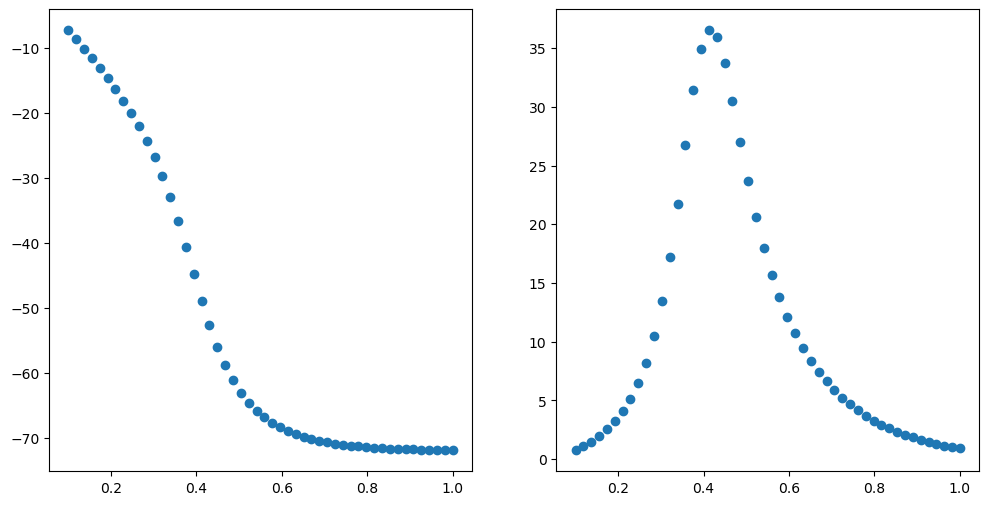

In [7]:
beta_range  = np.linspace(.1, 1 , num = 50)
average_energy, specific_heat = model.calculate_thermo(beta_range)
# Plot zeros of the partition function in terms of h and fugacity(z)
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].scatter( beta_range, average_energy)
axes[1].scatter( beta_range, specific_heat)
plt.show()
